In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")            #comment this line to run with GPU
#tpr = torch.hub.load('yangsenius/TransPose:main', 'tpr_a4_256x192', pretrained=True)
#tph = torch.hub.load('yangsenius/TransPose:main', 'tph_a4_256x192', pretrained=True, device=device)


#print(tph)
DATASET_PATH = './dataset/'
positions = os.listdir(DATASET_PATH)
#print(os.listdir(DATASET_PATH+entries[0]))
images = list()

def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

class YogaPoseDataset(Dataset):

    def __init__(self, dataset_path, size=(256,192)):
        self.data_path = dataset_path
        # call to init the data
        self.size = size
        self._init_data()

    def _init_data(self):
        positions = os.listdir(self.data_path)
        images = list()
        labels = list()
        for idx, position in enumerate(positions):
            for file in os.listdir(DATASET_PATH + position):
                if not file.endswith('.gif'):
                    f = cv2.imread(DATASET_PATH + position + '/' + file,cv2.IMREAD_COLOR)

                    #print(position + '/' + file)
                    #print(f.shape)
                    height,width, channels = f.shape
                    if height > width:
                        scale_percent = self.size[0]/height
                        f = cv2.resize(f,(int(width*scale_percent),self.size[0]))
                        if f.shape[1] > self.size[1]:
                            scale_percent = self.size[1]/width
                            f = cv2.resize(f,(self.size[1],int(height*scale_percent)))
                    else:
                        scale_percent = self.size[1]/width
                        f = cv2.resize(f,(self.size[1],int(height*scale_percent)))
                        if f.shape[0] > self.size[1]:
                            scale_percent = self.size[0]/height
                            f = cv2.resize(f,(int(width*scale_percent),self.size[0]))

                    height,width, channels = f.shape
                    #print(f.shape,"after resize")
                    f = cv2.copyMakeBorder(f, self.size[0]-height, 0, self.size[1]-width, 0, cv2.BORDER_CONSTANT,value=0)
                    #print(f.shape,"after padding")
                    #if torch.FloatTensor(f.getdata()).size()[1] != 3: f.show()
                    data = torch.reshape(torch.FloatTensor(f).to(device),(3,self.size[0],self.size[1]))
                    #print(data.shape)
                    #print(data.size())
                    ##images.append(data)
                    ##labels.append(torch.tensor(idx))
                    images.append((idx,data))


        #print(images)
        ##images = torch.stack(images)
        ##labels = torch.stack(labels)
        #print(labels)
        #print(images.size())
        ##mask = np.arange(labels.size()[0])
        np.random.shuffle(images)
        self.images = images
        #print(type(images),type(images[0]))
        ##self.images = images[mask]
        ##self.labels = labels[mask]
        #print(self.labels.size())
        #print(self.labels)

    def __len__(self):
        # returns the number of samples in our dataset
        return len(self.images)




    def getData(self):
        return self.images

    #def getY(self):
    #    return self.labels

    def __getitem__(self, idx):
        # returns the idx-th sample
        return self.images[idx]

    def collate_fn(self,data):
        #print(len(data),data)
        #print(data[0].size())
        #print(data[1].size())
        #print('lwwwwwwwwwwwwwww',[x[0].size() for x in data])
        #print(torch.cat([x[0] for x in data]).size(),data[0][0].size())
        #print(torch.stack([x[1] for x in data]).size(),data[0][1],[x[1] for x in data])
        Xs = torch.stack([x[1] for x in data])
        #print(Xs.size())
        y = torch.stack([torch.tensor(x[0]) for x in data])
        #print(y.size())
        return Xs,y


In [10]:
dataset = YogaPoseDataset(DATASET_PATH)
split_position = int((len(dataset)//10)*7)
trainset = dataset[:split_position]
testset = dataset[split_position:]
trainset = dataset[:10]
print(trainset)

libpng warning: Ignoring incorrect cHRM white(.34575,.35855) r(.6485,.33088)g(.32121,.59787)b(.15589,.06604) when sRGB is also present


[(30, tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [255., 254., 253.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 237., 229., 230.],
         [255., 255., 255.,  ..., 255., 253., 251.]],

        [[255., 254., 253.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 237., 229., 230.],
         [255., 255., 255.,  ..., 255., 253., 252.],
         ...,
         [247., 235., 233.,  ..., 227., 214., 216.],
         [241., 228., 230.,  ...,  72., 152.,  94.],
         [ 55., 132.,  72.,  ..., 247., 235., 233.]],

        [[247., 235., 233.,  ..., 227., 214., 216.],
         [241., 228., 230.,  ...,  48., 106.,  65.],
         [ 37.,  92.,  52.,  ..., 247., 235., 233.],
         ...,
         [140., 103., 200.,  ..., 152., 120., 205.],
         [152., 120., 204.,  ..., 151., 125., 217.],
         [151., 125., 217.,  ...,  90.,  75., 1

In [11]:
dataset[0]

(30,
 tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [255., 254., 253.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 237., 229., 230.],
          [255., 255., 255.,  ..., 255., 253., 251.]],
 
         [[255., 254., 253.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 237., 229., 230.],
          [255., 255., 255.,  ..., 255., 253., 252.],
          ...,
          [247., 235., 233.,  ..., 227., 214., 216.],
          [241., 228., 230.,  ...,  72., 152.,  94.],
          [ 55., 132.,  72.,  ..., 247., 235., 233.]],
 
         [[247., 235., 233.,  ..., 227., 214., 216.],
          [241., 228., 230.,  ...,  48., 106.,  65.],
          [ 37.,  92.,  52.,  ..., 247., 235., 233.],
          ...,
          [140., 103., 200.,  ..., 152., 120., 205.],
          [152., 120., 204.,  ..., 151., 125., 217.],
          [151., 125., 217

In [12]:
class PoseClassifier(nn.Module):
    def __init__(self, n_class, fine_tune=False, pretrained=True):
        super(PoseClassifier, self).__init__()

        self.tph = torch.hub.load('yangsenius/TransPose:main', 'tph_a4_256x192', pretrained=True, device=device)
        self.fc1 = nn.Linear(52224,10000).to(device)
        self.fc2 = nn.Linear(10000,1000).to(device)
        self.fc3 = nn.Linear(1000,n_class).to(device)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = x.to(device)
        #print(x.size(),"INPUT")
        out = self.tph(x)
        #out = self.relu(out)
        #print(out.size(), "AFTER TPH")
        #out = torch.einsum("abcd -> abc",out)
        #print(out.size())
        out = torch.reshape(out,(out.size(0),-1))
        #print(out.size())
        out = self.fc1(out)
        #m = nn.BatchNorm1d(1000,device=device)
        #out = m(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return torch.softmax(out,dim=1)


In [13]:
num_classes = 107
model = PoseClassifier(n_class=num_classes)
num_epochs = 50
batch_size = 1
learning_rate = 1e-4
learning_rate_decay = 0.99
params_to_update = model.parameters()
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

>>Load pretrained weights from url: https://github.com/yangsenius/TransPose/releases/download/Hub/tp_h_48_256x192_enc4_d96_h192_mh1.pth
Successfully loaded model  (on cpu) with pretrained weights!


Using cache found in /home/michele/.cache/torch/hub/yangsenius_TransPose_main


In [14]:
model.to(device)
fine_tune=True
if fine_tune:
    params_to_update = []
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    for param in model.tph.parameters():
        param.requires_grad = False
    for p in model.parameters():
        if p.requires_grad == True:
            params_to_update.append(p)
else:
    params_to_update = model.parameters()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size,shuffle=False,collate_fn=dataset.collate_fn)
#val_loader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size,shuffle=False,collate_fn=dataset.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size,shuffle=False,collate_fn=dataset.collate_fn)
# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []

In [15]:

for image,label in train_loader:
    print(image.size(),label.size(),image,label)
    break


torch.Size([1, 3, 256, 192]) torch.Size([1]) tensor([[[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [255., 254., 253.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 237., 229., 230.],
          [255., 255., 255.,  ..., 255., 253., 251.]],

         [[255., 254., 253.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 237., 229., 230.],
          [255., 255., 255.,  ..., 255., 253., 252.],
          ...,
          [247., 235., 233.,  ..., 227., 214., 216.],
          [241., 228., 230.,  ...,  72., 152.,  94.],
          [ 55., 132.,  72.,  ..., 247., 235., 233.]],

         [[247., 235., 233.,  ..., 227., 214., 216.],
          [241., 228., 230.,  ...,  48., 106.,  65.],
          [ 37.,  92.,  52.,  ..., 247., 235., 233.],
          ...,
          [140., 103., 200.,  ..., 152., 120., 205.],
          [152., 120., 204.,  ..., 151., 1

Validataion accuracy is: 40.0 %
Validataion accuracy is: 20.0 %
Validataion accuracy is: 20.0 %
Validataion accuracy is: 20.0 %
Not saving the model
Validataion accuracy is: 20.0 %
Not saving the model
Validataion accuracy is: 30.0 %
Not saving the model
Early stopping
Validataion accuracy is: 30.0 %
Not saving the model
Early stopping
Validataion accuracy is: 30.0 %
Not saving the model
Early stopping
Validataion accuracy is: 30.0 %
Not saving the model
Early stopping
Validataion accuracy is: 40.0 %
Saving the model
Validataion accuracy is: 50.0 %
Saving the model
Validataion accuracy is: 40.0 %
Not saving the model
Validataion accuracy is: 50.0 %
Saving the model
Validataion accuracy is: 60.0 %
Saving the model
Validataion accuracy is: 40.0 %
Not saving the model
Validataion accuracy is: 60.0 %
Saving the model
Validataion accuracy is: 60.0 %
Saving the model
Validataion accuracy is: 60.0 %
Saving the model
Validataion accuracy is: 60.0 %
Saving the model
Validataion accuracy is: 60.

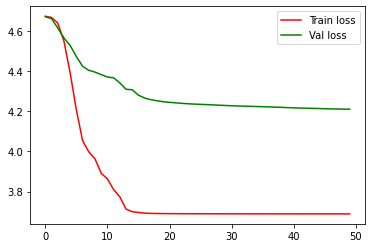

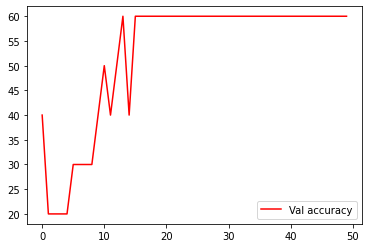

In [16]:
model.to(device)
params_to_update = model.parameters()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
#train_loader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size,shuffle=False)
#val_loader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size,shuffle=False)
# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
#best_model = type(model)(num_classes, fine_tune, pretrained) # get a new instance
for epoch in range(num_epochs):

    model.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_iter += loss.item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    loss_train.append(loss_iter/(len(train_loader)*batch_size))


    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)


    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            #print(outputs)
            #print(torch.sum(outputs[0]),torch.sum(outputs[1]))
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            #print("PREDICTED",predicted)
            #print("LABELS",labels)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            loss_iter += loss.item()

        loss_val.append(loss_iter/(len(val_loader)*batch_size))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)

        print('Validataion accuracy is: {} %'.format(accuracy))
        #################################################################################
        # TODO: Q2.b Use the early stopping mechanism from previous questions to save   #
        # the model with the best validation accuracy so-far (use best_model).          #
        #################################################################################

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        early_stop = False
        patience = 3
        if epoch > patience - 1:
            for j in range(patience - 1):
                if max(accuracy_val) > list(reversed(accuracy_val))[j]:
                    if "not_improving_epochs" in locals(): not_improving_epochs += 1
                    else: not_improving_epochs = 1
                    print('Not saving the model')
                else:
                    not_improving_epochs = 0
                    best_model = model
                    print("Saving the model")
                    break
                if not_improving_epochs >= patience:
                    early_stop = True
                    print('Early stopping')
                    break
                break




plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Val loss')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(accuracy_val, 'r', label='Val accuracy')
plt.legend()
plt.show()